# MLB pitch classifier
This script takes two months worth of statcast data from the 2022 season (~250,000 pitches) and builds two machine learning models (Random Forest and Logistic Regression) to determine what type of pitch is thrown. The data is cleaned and processed such that only the fields that make sense to a distinct pitch are used. This includes:
* Release Speed
* Release spin rate
* Spin axis
* Velocity x, y, and z vectors at 50 feet from home plate
* Acceleration x, y, and z vectors at 50 feet from home plate
* Horizontal and vertical movement

Import the main processing packages used in the script

In [199]:
from baseball_scraper import statcast # https://pypi.org/project/baseball-scraper/
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import time

### Skip next cell **UNLESS** you do not have the pitch_Data.csv or you want a different time selection

In [201]:
#### This cell can take minutes to run depending on the amount of data you want #####
#data = statcast(start_dt='2022-05-01', end_dt='2022-05-10', team=None, verbose=True)
#data.to_csv("Pitch_Data_small.csv",index=False)

### Read in the data set from the created .csv file

In [233]:
data = pd.read_csv("Pitch_Data.csv")

In [234]:
data.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,3105,KC,2022-07-01,87.6,-2.64,5.61,"Robertson, David",646240.0,502085.0,field_out,...,6.0,5.0,6.0,5.0,6.0,Infield shift,Strategic,37.0,0.035,-0.099
1,3239,KC,2022-07-01,87.2,-2.68,5.59,"Robertson, David",680776.0,502085.0,field_out,...,6.0,5.0,6.0,5.0,6.0,Standard,Standard,45.0,0.052,-0.148
2,3321,KC,2022-07-01,86.5,-2.60,5.65,"Robertson, David",680776.0,502085.0,NaN,...,6.0,5.0,6.0,5.0,6.0,Standard,Standard,38.0,0.000,-0.031
3,3435,KC,2022-07-01,87.0,-2.63,5.64,"Robertson, David",680776.0,502085.0,NaN,...,6.0,5.0,6.0,5.0,6.0,Standard,Strategic,35.0,0.000,0.023
4,3581,FC,2022-07-01,93.9,-2.46,5.73,"Robertson, David",608701.0,502085.0,field_out,...,6.0,5.0,6.0,5.0,6.0,Standard,Standard,191.0,0.071,-0.158


**Most of the columns do not have a lot to do with etermining the pitch type so only a small subset of the 93 columns are used.**

In [235]:
# These columns are of interest
cols = ['pitch_type', 'release_speed','release_spin_rate','spin_axis',
        'pfx_x','pfx_z','vx0', 'vy0', 'vz0', 'ax', 'ay', 'az']
df = data[cols]

In [236]:
# Split the data into X and y data sets for training
X = df.drop('pitch_type', axis=1)
X = X.fillna(0)
# Fix a couple of the pitch types that are not very helpful (FA = fastball so convert those to FF = 4seam)
y = df['pitch_type']
y = y.replace("FA","FF")
y = y.fillna("UN")

In [237]:
# Pitch option and their names
pitches = {'AB': 'Automatic Ball',
    'AS': 'Automatic Strike',
    'CH': 'Change-up',
    'CU': 'Curveball',
    'CS': 'Slow Curve',
    'EP': 'Eephus',
    'FC': 'Cutter',
    'FF': '4S-FB',
    'FO': 'Forkball',
    'FS': 'Splitter',
    'SI': '2S-FB/Sinker',
    'GY': 'Gyroball',
    'IN': 'Intentional Ball',
    'KC': 'Knuckle Curve',
    'KN': 'Knuckleball',
    'NP': 'No Pitch',
    'PO': 'Pitchout',
    'SC': 'Screwball',
    'SL': 'Slider',
    'ST': 'Sweeper',
    'SV': 'Slurve',
    'UN': 'Unknown'
    }

In [238]:
# Check the unique pitches shown in the data set
y.unique()

array(['KC', 'FC', 'SL', 'FS', 'FF', 'SI', 'ST', 'CH', 'CU', 'CS', 'PO',
       'SV', 'EP', 'KN', 'UN'], dtype=object)

----
## The Data has been cleaned at this point to the fields of interest and the labels
Import the sklearn packages needed for the Random Forest Classifier method 

In [239]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

Perform a Train Test split on the data with 10% for testing

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=814)

# Use a Random Forest Classifier model

In [241]:
# Create an instance of the RandomForestClassifier class
clf = RandomForestClassifier(n_estimators=100,random_state=814)

In [242]:
# Create an instance of the scalar class in order to normalize the data that is in differnet units and magnitudes
scaler = StandardScaler()
# Fit and transfor the X_train data and just transforn the X_test data
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

**Run the RandomForestClassifier on the scaled training data**

In [243]:
rf_start = time.time()
clf.fit(scaled_X_train, y_train)
rf_end = time.time()
print(f'The RandomForestClassifier took {rf_end-rf_start:.2f}s to run')

The RandomForestClassifier took 59.46s to run


**Predict the labels of the test data set**

In [244]:
rf_y_pred = clf.predict(scaled_X_test)

# Determine the accuracy and present the results of the **Random Forest**

In [245]:
accuracy_score(y_test, rf_y_pred)

0.8760694307337941

In [246]:
# Find the accuracy manually
sum(rf_y_pred == y_test)/len(y_test) 
# 0.8624547548535703 with 10 estimators - 6.47 seconds
# 0.8760694307337941 with 100 estimators - 61.10 seconds
# 0.8821744834371925 with 1000 estimators

0.8760694307337941

In [247]:
# Create some dataframes for plots and labels for those charts
ptypes = list(y_test.unique())
rf_matrix = pd.DataFrame(confusion_matrix(y_test,rf_y_pred))
rf_matrix_percent = (rf_matrix.T.transform(lambda x: x / x.sum()).fillna(0)*100).T
total_pitches = y_test.value_counts()
types = sorted(ptypes)
names = res = [pitches[i] +" ("+i+") - " + str(total_pitches.loc[i]) for i in types]

## Plot a confusion matrix showing the pitches and percentage labeled correct and incorrect per pitch

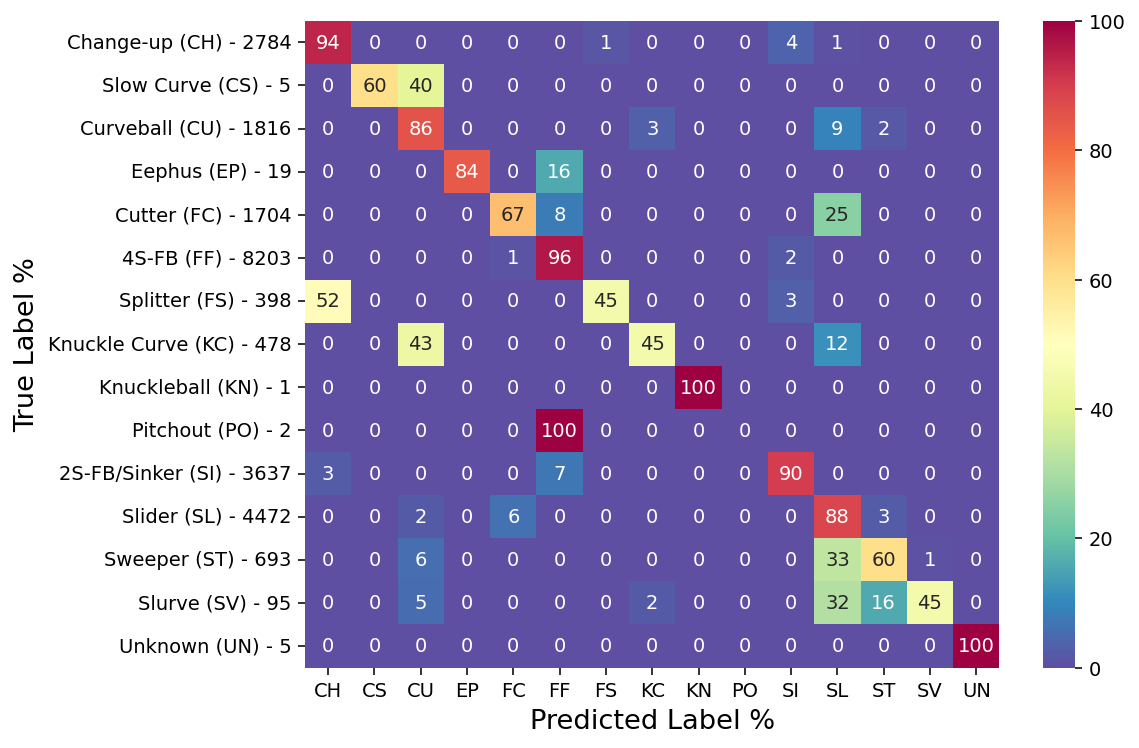

In [248]:
plt.figure(figsize=(8,6), dpi=140)
s = sns.heatmap(data = rf_matrix_percent ,xticklabels=types, yticklabels=names, 
            annot=True, fmt=".0f", cmap= 'Spectral_r',vmin=0);
s.set_xlabel('Predicted Label %', fontsize=14)
s.set_ylabel('True Label %', fontsize=14)
plt.savefig("RandomForest", bbox_inches='tight', dpi=120)

# Use a Logistic Regression model

In [249]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

**Keep exact same train and test data from the first model in order to fairly compare**

In [262]:
# scaler = StandardScaler()
# scaled_X_train = scaler.fit_transform(X_train)
# scaled_X_test = scaler.transform(X_test)

In [263]:
# Create an instance of the RandomForestClassifier class
log_model = LogisticRegression(max_iter=1000, solver='saga', multi_class='auto', random_state=814)
#log_modelCV = LogisticRegressionCV(max_iter=1000)

**Run the LogisticRegression on the scaled training data**

In [264]:
log_start = time.time()
log_model.fit(scaled_X_train, y_train)
log_end = time.time()
print(f'The LogisticRegression took {log_end-log_start:.2f}s to run')

The LogisticRegression took 77.23s to run


**Predict the labels of the test data set**

In [265]:
log_y_pred = log_model.predict(scaled_X_test)

# Determine the accuracy and present the results of the **Logistic Regression**

In [266]:
accuracy_score(y_test, log_y_pred)
# 0.7627920368542284 with 100 interations (no CV) - 77.06 seconds
# 0.7627920368542284 with 1000 interations (no CV) - 80.30 seconds

0.7627920368542284

In [267]:
sum(log_y_pred == y_test)/len(y_test) 

0.7627920368542284

In [268]:
ptypes = list(y_test.unique())
log_matrix = pd.DataFrame(confusion_matrix(y_test, log_y_pred))
log_matrix_percent = (log_matrix.T.transform(lambda x: x / x.sum()).fillna(0)*100).T
total_pitches = y_test.value_counts()
# types = sorted(ptypes)
# names = res = [pitches[i] +"("+i+") - " + str(total_pitches.loc[i]) for i in types]

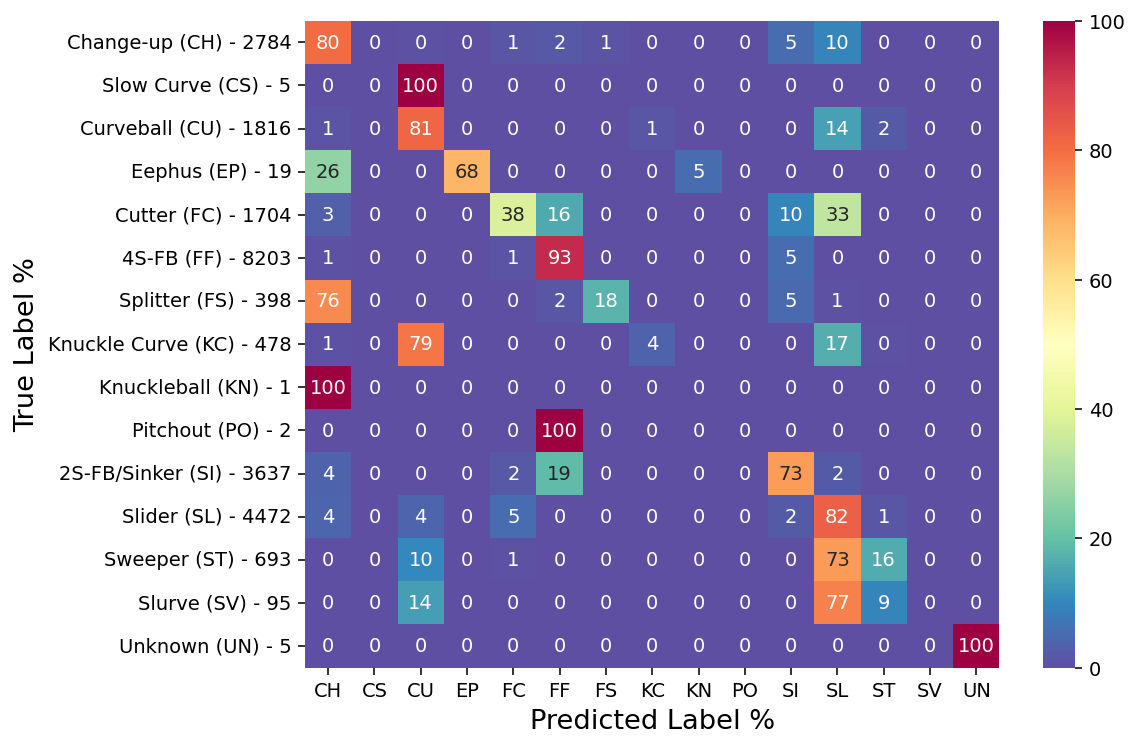

In [269]:
plt.figure(figsize=(8,6), dpi=140)
s = sns.heatmap(data = log_matrix_percent ,xticklabels=types, yticklabels=names, 
            annot=True, fmt=".0f", cmap= 'Spectral_r',vmin=0);
s.set_xlabel('Predicted Label %', fontsize=14)
s.set_ylabel('True Label %', fontsize=14)
plt.savefig("LogisticRegression", bbox_inches='tight', dpi=120)

# Compare the two models

In [270]:
print(f'The accuracy score of the RandomForest was {accuracy_score(y_test,rf_y_pred):.5f}, in a time of {rf_end-rf_start:.2f}s')
print(f'The accuracy score of the LogisticRegression was {accuracy_score(y_test,log_y_pred):.5f}, in a time of {log_end-log_start:.2f}s')

The accuracy score of the RandomForest was 0.87607, in a time of 59.46s
The accuracy score of the LogisticRegression was 0.76279, in a time of 77.23s


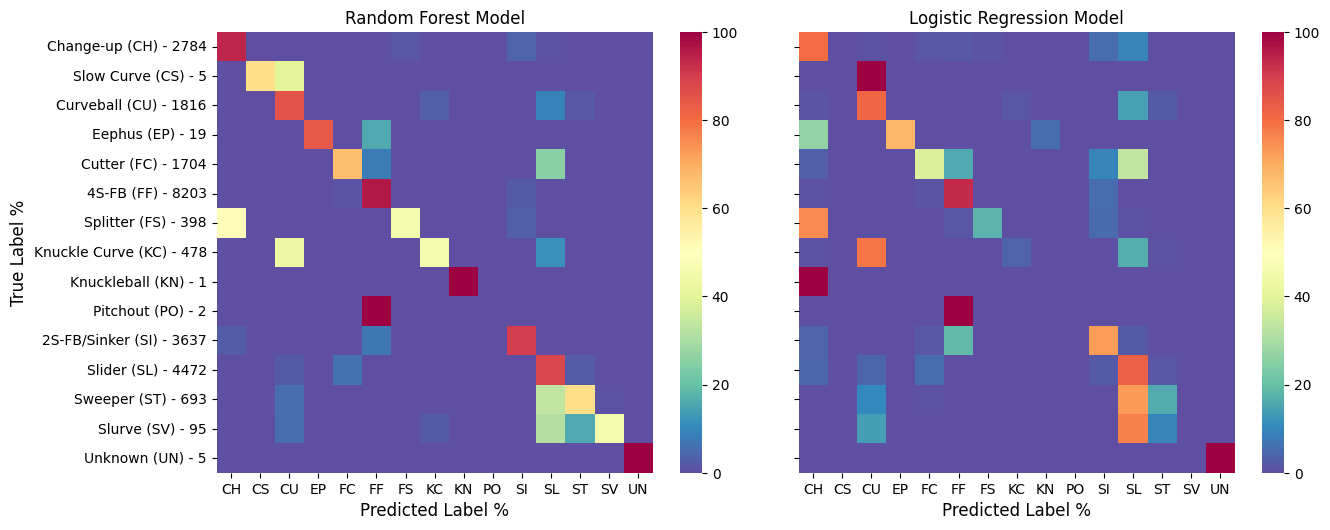

In [271]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
fig.tight_layout()
s1 = sns.heatmap(data = rf_matrix_percent ,xticklabels=types, yticklabels=names, 
            annot=False, fmt=".0f", cmap= 'Spectral_r',vmin=0, ax=ax1);
s1.set_xlabel('Predicted Label %', fontsize=12)
s1.set_ylabel('True Label %', fontsize=12)
s1.title.set_text("Random Forest Model")
s2 = sns.heatmap(data = log_matrix_percent ,xticklabels=types, yticklabels=names, 
            annot=False, fmt=".0f", cmap= 'Spectral_r',vmin=0, ax=ax2);
s2.set_xlabel('Predicted Label %', fontsize=12)
s2.title.set_text("Logistic Regression Model")
fig.savefig("Comparison", bbox_inches='tight',dpi=120)

In [260]:
#print(classification_report(y_test, rf_p_vals, zero_division=0))

In [261]:
#print(classification_report(y_test, log_y_pred, zero_division=0))

# Results
## There is a lot of overlap in the two model's predictions.
## The Logistic Regression is faster on the small data set but still less accurate
## The Random forest is Faster and more accurate on the large data set
